In [1]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/kaggle/working/6D_pose"   #Modify here for kaggle
branch = "pose_rgbd"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    # %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


Cloning into '6D_pose'...
remote: Enumerating objects: 576, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 576 (delta 134), reused 147 (delta 69), pack-reused 334 (from 1)
Receiving objects: 100% (576/576), 8.23 MiB | 26.24 MiB/s, done.
Resolving deltas: 100% (300/300), done.
Cloned https://github.com/fraco03/6D_pose.git to /kaggle/working/6D_pose


In [ ]:
%cd ..
!gdown --fuzzy https://drive.google.com/file/d/1zNthSyiBdPUfn7BmUKPbKoGgQdG1vGnS/view?usp=drive_link -O Linemod_preprocessed.zip
!unzip Linemod_preprocessed.zip
%cd 6D_pose

In [ ]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

In [5]:
%mv Linemod_preprocessed working/

In [6]:
# dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle
# dataset_root = "../../Linemod_preprocessed"
# dataset_root = "/content/Linemod_preprocessed"
dataset_root = "/kaggle/working/Linemod_preprocessed"

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")



✅ Setup complete!
📁 Dataset path: /kaggle/working/Linemod_preprocessed


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%mv Linemod_preprocessed ./working

In [7]:
!pip install plyfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.6 MB/s eta 0:00:00


In [ ]:
import importlib

importlib.reload(sys.modules['src.pose_rgbd.dataset'])

In [8]:
from src.pose_rgbd.loss import GeodesicLoss
from src.pose_rgbd.dataset import LineModPoseDepthDataset

train_dataset = LineModPoseDepthDataset(
    root_dir=dataset_root,
    split="train"
)

test_dataset = LineModPoseDepthDataset(
    root_dir=dataset_root,
    split="test"
)


✅ LineModConfig initialized: /kaggle/working/Linemod_preprocessed
 Loaded LineModPoseDepthDataset
   Split: train (Ratio: 0.8)
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 12610
 Loaded LineModPoseDepthDataset
   Split: test (Ratio: 0.8)
   Objects: [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 3163


In [9]:
sample = train_dataset[0]

print(f"Sample keys: {sample.keys()}")
print(f"Depth shape: {sample['depth'].shape}")
print(f"RGB shape: {sample['image'].shape}")

Sample keys: dict_keys(['image', 'depth', 'img_id', 'img_path', 'rotation', 'translation', '3D_center', 'object_id', 'class_idx', 'cam_K', 'bbox'])
Depth shape: torch.Size([1, 224, 224])
RGB shape: torch.Size([3, 224, 224])


In [11]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import MSELoss
# from src.pose_rgbd.model import RotationPredictionModel
from src.pose_rgbd.model import RGBDRotationModel
from src.pose_rgbd.dataset import LineModPoseDepthDataset
from src.pose_rgbd.loss import GeodesicLoss


# Configurazione del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
from utils.linemod_config import get_linemod_config
import numpy as np
import torch

# dataset_root = "../../Linemod_preprocessed_small"  # Adjust path as needed
linemod_config = get_linemod_config(dataset_root)

all_model_points = []
NUM_POINTS = 1000  # Number of points to sample from each model
VALID_OBJ_IDS = [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15] 
for obj_id in VALID_OBJ_IDS:
    model_points = linemod_config.get_model_3d(obj_id, unit='m')  # (N, 3)
    if model_points.shape[0] >= NUM_POINTS:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=False)
    else:
        choice = np.random.choice(model_points.shape[0], NUM_POINTS, replace=True)
    model_points = model_points[choice, :]
    all_model_points.append(torch.tensor(model_points, dtype=torch.float32))
all_model_points = torch.stack(all_model_points, dim=0)  # (Num_Classes, NUM_POINTS, 3)
all_model_points = all_model_points.to(device)

max_obj_id = max(VALID_OBJ_IDS)

# Create a lookup table: obj_id -> index
obj_id_to_idx = torch.full((max_obj_id + 1,), -1, dtype=torch.long, device=device)
for idx, obj_id in enumerate(VALID_OBJ_IDS):
    obj_id_to_idx[obj_id] = idx

In [13]:
all_model_points.shape

torch.Size([13, 1000, 3])

In [33]:
from src.pose_rgbd.loss import MultiObjectPointMatchingLoss
import torch.nn as nn

model = RGBDRotationModel(pretrained=True)

if torch.cuda.device_count() > 1:
    print(f"🔥 Using {torch.cuda.device_count()} GPU!")
    model = nn.DataParallel(model)

model = model.to(device)

# Loss function and optimizer
criterion = MultiObjectPointMatchingLoss(all_model_points)
optimizer = Adam(model.parameters(), lr=1e-4)

🔥 Using 2 GPU!


In [34]:
from torch.utils.data import DataLoader

batch_size = 32  #double GPU

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [35]:
from tqdm import tqdm
import os
import datetime
from itertools import islice
from datetime import datetime

# Load best model

# Ciclo di training
num_epochs = 15
best_test_loss = float('inf')
# checkpoint_dir = "checkpoints"
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# checkpoint_dir = f'/content/drive/MyDrive/runs/POINT_MATCH_{timestamp}' # modify here for kaggle
checkpoint_dir = f'/kaggle/working/POINT_MATCH_{timestamp}'
os.makedirs(checkpoint_dir, exist_ok=True)
# val_batches_limit = 50

# Track losses for plotting
train_losses = []
test_losses = []

batch_size = 32

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    train_pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
    for batch in train_pbar:
        rgb = batch['image'].to(device)  # RGB image (B, 3, H, W)
        depth = batch['depth'].to(device)  # Depth (B, 1, H, W)
        rotations = batch['rotation'].to(device)  # GT quaternion (B, 4)
        obj_ids = batch['object_id'].to(device)  # Object IDs (B,)
        obj_ids = obj_id_to_idx[obj_ids]  # Map to indices (B,)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(rgb, depth)

        # Calcolo della loss
        loss = criterion(outputs, rotations, obj_ids)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        train_pbar.set_postfix({'loss': epoch_loss / (train_pbar.n + 1)})

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    test_loss = 0.0

    # val_iterator = islice(test_loader, val_batches_limit)
    val_pbar = tqdm(test_loader, total=val_batches_limit, desc="Validating")
    count_batches = 0
    with torch.no_grad():
        for batch in val_pbar:
            rgb = batch['image'].to(device)
            depth = batch['depth'].to(device)
            rotations = batch['rotation'].to(device)
            obj_ids = batch['object_id'].to(device)  # Object IDs (B,)
            obj_ids = obj_id_to_idx[obj_ids].to(device)  # Map to indices (B,)

            outputs = model(rgb, depth)
            loss = criterion(outputs, rotations, obj_ids)
            test_loss += loss.item()
            val_pbar.set_postfix({'loss': test_loss / (val_pbar.n + 1)})
            count_batches+=1

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}")

    # Save checkpoint if test loss improved
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'test_loss': avg_test_loss,
        }, checkpoint_path)
        print(f"✅ Checkpoint saved! Best Test Loss: {best_test_loss:.4f}")
    else:
        print(f"⚠️  No improvement. Best Test Loss: {best_test_loss:.4f}")

Epoch [1/15] - Training: 100%|██████████| 394/394 [02:03<00:00,  3.19it/s, loss=0.051] 
Validating: 99it [00:29,  3.37it/s, loss=0.03]                          


Epoch [1/15], Test Loss: 0.0297
✅ Checkpoint saved! Best Test Loss: 0.0297


Epoch [2/15] - Training: 100%|██████████| 394/394 [02:03<00:00,  3.19it/s, loss=0.031] 
Validating: 99it [00:29,  3.39it/s, loss=0.0209]                        


Epoch [2/15], Test Loss: 0.0206
✅ Checkpoint saved! Best Test Loss: 0.0206


Epoch [3/15] - Training: 100%|██████████| 394/394 [02:04<00:00,  3.18it/s, loss=0.0252]
Validating: 99it [00:29,  3.36it/s, loss=0.0184]                        


Epoch [3/15], Test Loss: 0.0182
✅ Checkpoint saved! Best Test Loss: 0.0182


Epoch [4/15] - Training: 100%|██████████| 394/394 [02:04<00:00,  3.16it/s, loss=0.0232]
Validating: 99it [00:29,  3.37it/s, loss=0.0161]                        


Epoch [4/15], Test Loss: 0.0159
✅ Checkpoint saved! Best Test Loss: 0.0159


Epoch [5/15] - Training: 100%|██████████| 394/394 [02:03<00:00,  3.18it/s, loss=0.0204]
Validating: 99it [00:29,  3.38it/s, loss=0.015]                         


Epoch [5/15], Test Loss: 0.0148
✅ Checkpoint saved! Best Test Loss: 0.0148


Epoch [6/15] - Training: 100%|██████████| 394/394 [02:04<00:00,  3.16it/s, loss=0.0192]
Validating: 99it [00:29,  3.37it/s, loss=0.0138]                        


Epoch [6/15], Test Loss: 0.0137
✅ Checkpoint saved! Best Test Loss: 0.0137


Epoch [7/15] - Training: 100%|██████████| 394/394 [02:04<00:00,  3.17it/s, loss=0.0182]
Validating: 99it [00:29,  3.37it/s, loss=0.0136]                        


Epoch [7/15], Test Loss: 0.0135
✅ Checkpoint saved! Best Test Loss: 0.0135


Epoch [8/15] - Training: 100%|██████████| 394/394 [02:04<00:00,  3.16it/s, loss=0.0182]
Validating: 99it [00:29,  3.37it/s, loss=0.0157]                        


Epoch [8/15], Test Loss: 0.0156
⚠️  No improvement. Best Test Loss: 0.0135


Epoch [9/15] - Training: 100%|██████████| 394/394 [02:03<00:00,  3.18it/s, loss=0.0183]
Validating: 99it [00:29,  3.40it/s, loss=0.0135]                        


Epoch [9/15], Test Loss: 0.0135
✅ Checkpoint saved! Best Test Loss: 0.0135


Epoch [10/15] - Training: 100%|██████████| 394/394 [02:04<00:00,  3.17it/s, loss=0.0173]
Validating: 99it [00:29,  3.39it/s, loss=0.013]                         


Epoch [10/15], Test Loss: 0.0130
✅ Checkpoint saved! Best Test Loss: 0.0130


Epoch [11/15] - Training: 100%|██████████| 394/394 [02:03<00:00,  3.18it/s, loss=0.0159]
Validating: 99it [00:29,  3.35it/s, loss=0.0117]                        


Epoch [11/15], Test Loss: 0.0115
✅ Checkpoint saved! Best Test Loss: 0.0115


Epoch [12/15] - Training: 100%|██████████| 394/394 [02:04<00:00,  3.16it/s, loss=0.0151]
Validating: 99it [00:29,  3.36it/s, loss=0.0119]                        


Epoch [12/15], Test Loss: 0.0118
⚠️  No improvement. Best Test Loss: 0.0115


Epoch [13/15] - Training: 100%|██████████| 394/394 [02:04<00:00,  3.17it/s, loss=0.0139]
Validating: 99it [00:29,  3.34it/s, loss=0.0119]                        


Epoch [13/15], Test Loss: 0.0117
⚠️  No improvement. Best Test Loss: 0.0115


Epoch [14/15] - Training: 100%|██████████| 394/394 [02:04<00:00,  3.16it/s, loss=0.0151]
Validating: 99it [00:29,  3.38it/s, loss=0.0158]                        


Epoch [14/15], Test Loss: 0.0156
⚠️  No improvement. Best Test Loss: 0.0115


Epoch [15/15] - Training: 100%|██████████| 394/394 [02:04<00:00,  3.16it/s, loss=0.0181]
Validating: 99it [00:29,  3.38it/s, loss=0.013]                         

Epoch [15/15], Test Loss: 0.0129
⚠️  No improvement. Best Test Loss: 0.0115


✅ Plot saved: /kaggle/working/POINT_MATCH_20251220_101524/loss_comparison.png


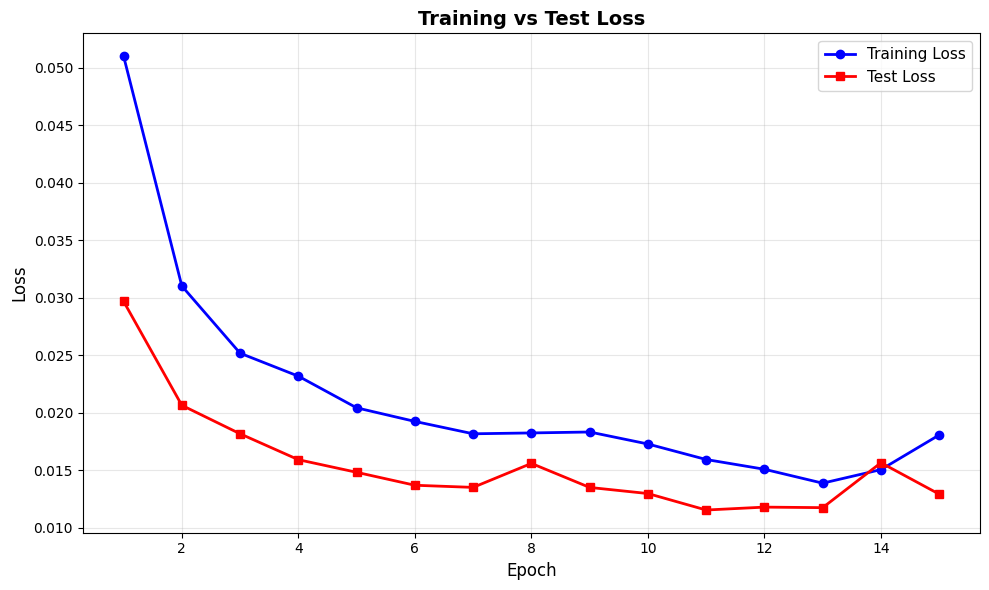

✅ Plot saved: /kaggle/working/POINT_MATCH_20251220_101524/training_loss.png


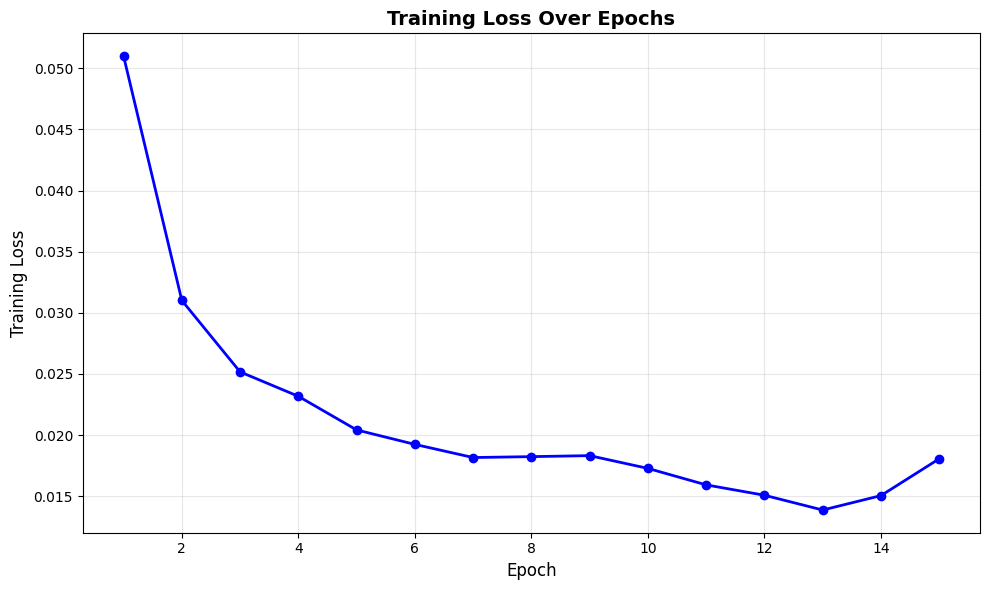

✅ Plot saved: /kaggle/working/POINT_MATCH_20251220_101524/test_loss.png


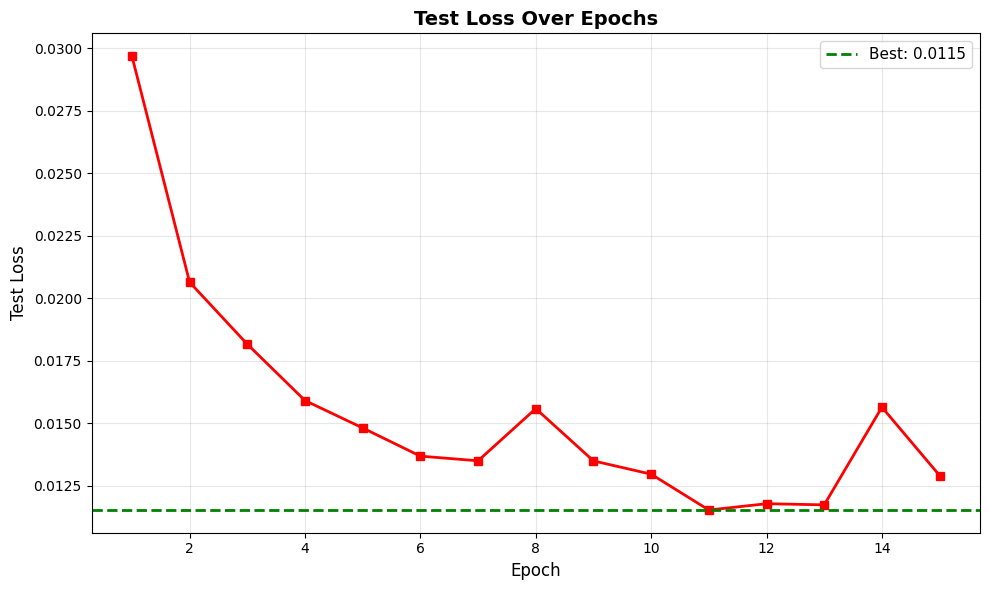


✅ All plots saved in '/kaggle/working/POINT_MATCH_20251220_101524' directory!


In [36]:
import matplotlib.pyplot as plt

# Create plots directory
# plots_dir = "plots"
plots_dir = checkpoint_dir
os.makedirs(plots_dir, exist_ok=True)

# Plot 1: Training vs Test Loss
plt.figure(figsize=(10, 6))
epochs_range = range(1, len(test_losses)+1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(range(1, len(test_losses)+1), test_losses, 'r-s', label='Test Loss', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training vs Test Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
loss_plot_path = os.path.join(plots_dir, "loss_comparison.png")
plt.savefig(loss_plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {loss_plot_path}")
plt.show()

# Plot 2: Only Training Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
train_loss_path = os.path.join(plots_dir, "training_loss.png")
plt.savefig(train_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {train_loss_path}")
plt.show()

# Plot 3: Only Test Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_losses)+1), test_losses, 'r-s', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test Loss', fontsize=12)
plt.title('Test Loss Over Epochs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=best_test_loss, color='g', linestyle='--', label=f'Best: {best_test_loss:.4f}', linewidth=2)
plt.legend(fontsize=11)
plt.tight_layout()
test_loss_path = os.path.join(plots_dir, "test_loss.png")
plt.savefig(test_loss_path, dpi=300, bbox_inches='tight')
print(f"✅ Plot saved: {test_loss_path}")
plt.show()

print(f"\n✅ All plots saved in '{plots_dir}' directory!")

In [37]:
# Save losses
import pickle


losses_dict = {
    'train_losses': train_losses,
    'test_losses': test_losses
}

losses_path = os.path.join(checkpoint_dir, "losses.pkl")
with open(losses_path, 'wb') as f:
    pickle.dump(losses_dict, f)


# Visualize samples

✅ Loaded best model from epoch 11 with test loss: 0.0115

📷 Visualizing sample 3122:
   Object ID: 15
   Image ID: 541

📊 Ground Truth vs Prediction:
   GT Rotation: [ 0.51493096  0.8259677   0.16073169 -0.1636725 ]
   Pred Rotation: [-0.5300895  -0.7917568  -0.23943508  0.1865398 ]
   GT Translation: [ 0.05273794 -0.0480328   0.71241915]

✅ Visualization saved!


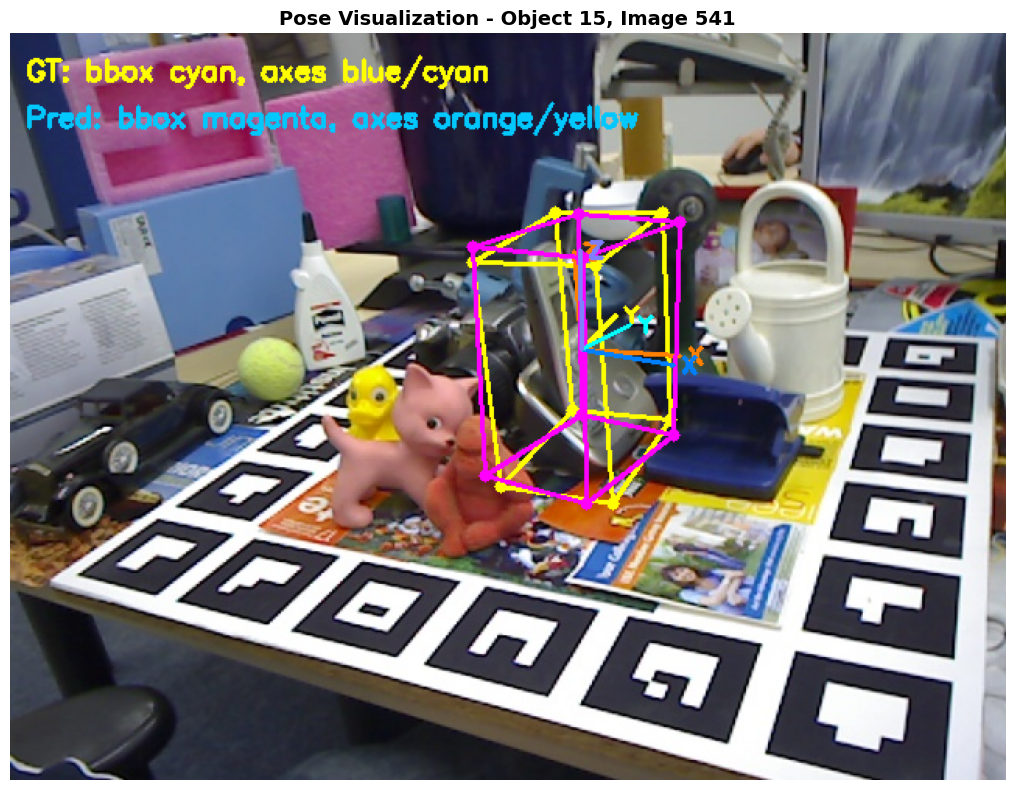

In [51]:
import random
import cv2
from utils.projection_utils import setup_projection_utils, visualize_pose_comparison, get_image
import matplotlib.pyplot as plt

# Setup projection utils
setup_projection_utils(dataset_root)

# Load best model
best_checkpoint_path = os.path.join(checkpoint_dir, "best_model.pth")
checkpoint = torch.load(best_checkpoint_path)

state_dict = checkpoint['model_state_dict']

# 2. Crea un nuovo dizionario senza il prefisso 'module.'
from collections import OrderedDict
new_state_dict = OrderedDict()

for k, v in state_dict.items():
    # Rimuovi 'module.' se presente all'inizio della chiave
    name = k[7:] if k.startswith('module.') else k 
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)
print(f"✅ Loaded best model from epoch {checkpoint['epoch']} with test loss: {checkpoint['test_loss']:.4f}")

# Select a random sample from test dataset
random_idx = random.randint(0, len(test_dataset) - 1)
sample = test_dataset[random_idx]

print(f"\n📷 Visualizing sample {random_idx}:")
print(f"   Object ID: {sample['object_id']}")
print(f"   Image ID: {sample['img_id']}")

# Get the original image
img_path = sample['img_path']
image_rgb = cv2.imread(str(img_path))
# image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB)

# Prepare input for model
rgb = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
depth = sample['depth'].unsqueeze(0).to(device)  # Add batch and channel dimensions

# Get model prediction
model.eval()
with torch.no_grad():
    pred_rotation = model(rgb, depth)[0].cpu().numpy()

# Get ground truth
gt_rotation = sample['rotation'].numpy()
gt_translation = sample['translation'].numpy()

# Get camera intrinsics
cam_K = sample['cam_K'].numpy()

print(f"\n📊 Ground Truth vs Prediction:")
print(f"   GT Rotation: {gt_rotation}")
print(f"   Pred Rotation: {pred_rotation}")
print(f"   GT Translation: {gt_translation}")

# Visualize pose comparison
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
img_vis = visualize_pose_comparison(
    image_rgb,
    object_id=sample['object_id'],
    cam_K=cam_K,
    gt_rotation=gt_rotation,
    gt_translation=gt_translation,
    pred_rotation=pred_rotation,
    pred_translation=gt_translation  # Using GT translation for now
)

# Convert BGR to RGB for matplotlib
img_vis_rgb = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
ax.imshow(img_vis_rgb)
ax.axis('off')
ax.set_title(f"Pose Visualization - Object {sample['object_id']}, Image {sample['img_id']}", fontsize=14, fontweight='bold')
plt.tight_layout()
# plt.savefig(os.path.join(plots_dir, f"pose_visualization_sample_{random_idx}.png"), dpi=150, bbox_inches='tight')
print(f"\n✅ Visualization saved!")
plt.show()

In [ ]:
!pip install trimesh

In [57]:
import torch
import numpy as np
import os
import trimesh
import pandas as pd
from collections import defaultdict, OrderedDict
from tqdm.auto import tqdm
from metrics.ADD_metric import compute_ADD_metric_quaternion, compute_ADDs_metric_quaternion
from src.pose_rgbd.model import RGBDRotationModel

# ==========================================
# 1. LOAD DATA AND DIAMETERS
# ==========================================
def load_models_info(models_dir, obj_ids, num_points=1000):
    """
    Loads sampled points and calculates the DIAMETER of each object.
    """
    point_cache = {}
    diameters = {}
    
    unique_ids = list(set(obj_ids))
    print(f"⏳ Loading info for {len(unique_ids)} models...")
    
    for oid in tqdm(unique_ids, desc="Mesh Analysis"):
        filename = f"obj_{int(oid):02d}.ply"
        path = os.path.join(models_dir, filename)
        
        if os.path.exists(path):
            mesh = trimesh.load(path)
            # 1. Sample points for ADD metric
            points, _ = trimesh.sample.sample_surface(mesh, num_points)
            point_cache[oid] = points / 1000.0  # Convert to Meters
            
            # 2. Diameter Calculation
            extents = mesh.extents / 1000.0  # Meters
            diameter = np.linalg.norm(extents)
            diameters[oid] = diameter
        else:
            print(f"⚠️ Missing model file: {path}")
            
    return point_cache, diameters

# ==========================================
# 2. COMPREHENSIVE EVALUATION WITH NAMES
# ==========================================
def evaluate_comprehensive(model_rot, dataloader, device, models_dir, output_csv="evaluation_results.csv"):
    model_rot.eval()
    
    # --- MAPPING ID TO NAMES (LineMOD Standard) ---
    id_to_name = {
        1: 'ape',
        2: 'benchvise',
        4: 'camera',
        5: 'can',
        6: 'cat',
        8: 'driller',
        9: 'duck',
        10: 'eggbox',
        11: 'glue',
        12: 'holepuncher',
        13: 'iron',
        14: 'lamp',
        15: 'phone'
    }

    # Define IDs to evaluate
    all_obj_ids = list(id_to_name.keys())
    
    # Load mesh data
    points_dict, diameters_dict = load_models_info(models_dir, all_obj_ids)
    
    # Data Structures
    errors_dict = defaultdict(list)
    accuracy_stats = defaultdict(lambda: {"correct": 0, "total": 0})

    # Objects requiring ADD-S (Symmetric)
    SYMMETRIC_OBJECTS = [10, 11]  # Eggbox, Glue
    
    print("\n🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...")
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            imgs = batch['image'].to(device)
            depths = batch['depth'].to(device)
            gt_quats = batch['rotation'].to(device)
            gt_trans = batch['translation'].to(device)
            obj_ids = batch['object_id']
            
            # Prediction
            pred_quats = model_rot(imgs, depths)
            
            batch_size = imgs.shape[0]
            for i in range(batch_size):
                curr_id = int(obj_ids[i])
                if curr_id not in points_dict: continue

                # Select Metric: ADD-S for symmetric, ADD for others
                metric = compute_ADDs_metric_quaternion if curr_id in SYMMETRIC_OBJECTS else compute_ADD_metric_quaternion
                
                # Calculate ADD Error (Meters)
                add_error = metric(
                    model_points=points_dict[curr_id],
                    gt_quat=gt_quats[i].cpu().numpy(),
                    gt_translation=gt_trans[i].cpu().numpy(),
                    pred_quat=pred_quats[i].cpu().numpy(),
                    pred_translation=gt_trans[i].cpu().numpy() 
                )
                
                # Store stats
                errors_dict[curr_id].append(add_error)
                
                threshold = diameters_dict[curr_id] * 0.1
                accuracy_stats[curr_id]["total"] += 1
                if add_error < threshold:
                    accuracy_stats[curr_id]["correct"] += 1

    # ==========================================
    # 3. PANDAS REPORT GENERATION
    # ==========================================
    results_data = []
    
    total_acc_correct = 0
    total_acc_count = 0
    total_errors = []

    sorted_ids = sorted(errors_dict.keys())
    
    for oid in sorted_ids:
        # Error stats
        mean_err_m = np.mean(errors_dict[oid])
        mean_err_cm = mean_err_m * 100.0
        total_errors.extend(errors_dict[oid])
        
        # Accuracy stats
        stats = accuracy_stats[oid]
        acc_perc = (stats["correct"] / stats["total"]) * 100.0 if stats["total"] > 0 else 0.0
        
        total_acc_correct += stats["correct"]
        total_acc_count += stats["total"]
        
        diam_cm = diameters_dict[oid] * 100.0
        
        # Get Class Name
        class_name = id_to_name.get(oid, "Unknown")

        # Append to list
        results_data.append({
            "Object ID": oid,
            "Class Name": class_name,  # <--- NEW COLUMN
            "Diameter (cm)": round(diam_cm, 2),
            "Mean ADD Error (cm)": round(mean_err_cm, 2),
            "Accuracy (%)": round(acc_perc, 2),
            "Samples": stats['total']
        })

    # Create DataFrame
    df = pd.DataFrame(results_data)

    # Calculate Global Stats
    global_mean_error_cm = np.mean(total_errors) * 100.0 if total_errors else 0.0
    global_accuracy = (total_acc_correct / total_acc_count * 100.0) if total_acc_count > 0 else 0.0

    # Add Global Row
    global_row = pd.DataFrame([{
        "Object ID": "GLOBAL",
        "Class Name": "ALL", # <--- NEW COLUMN PLACEHOLDER
        "Diameter (cm)": "-",
        "Mean ADD Error (cm)": round(global_mean_error_cm, 2),
        "Accuracy (%)": round(global_accuracy, 2),
        "Samples": total_acc_count
    }])
    
    df = pd.concat([df, global_row], ignore_index=True)

    # Print and Save
    print("\n" + "="*80)
    print("FINAL EVALUATION REPORT")
    print("="*80)
    # Set pandas display options to ensure columns align nicely
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    
    print(df.to_string(index=False))
    print("="*80)
    
    df.to_csv(output_csv, index=False)
    print(f"✅ Results saved to {output_csv}")

# --- USAGE ---

# 1. Define Paths
MODELS_ROOT = '/kaggle/working/Linemod_preprocessed/models'
checkpoint_path = checkpoint_dir + "/best_model.pth"

# 2. Load Checkpoint
print(f"📂 Loading checkpoint from: {checkpoint_path}")
data = torch.load(checkpoint_path, map_location=device)
state_dict = data['model_state_dict']

# 3. Clean State Dict (Remove 'module.' prefix from DataParallel)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] if k.startswith('module.') else k 
    new_state_dict[name] = v

# 4. Initialize and Load Model
model = RGBDRotationModel()
model.load_state_dict(new_state_dict)
model.to(device)

# 5. Run Evaluation
evaluate_comprehensive(
    model, 
    test_loader, 
    device, 
    MODELS_ROOT, 
    output_csv=checkpoint_dir + 'linemod_results.csv'
)

📂 Loading checkpoint from: /kaggle/working/POINT_MATCH_20251220_101524/best_model.pth
⏳ Loading info for 13 models...


Mesh Analysis:   0%|          | 0/13 [00:00<?, ?it/s]


🚀 Starting Comprehensive Benchmark (ADD Error + ADD-0.1d Accuracy)...


Evaluating:   0%|          | 0/99 [00:00<?, ?it/s]


FINAL EVALUATION REPORT
Object ID  Class Name Diameter (cm)  Mean ADD Error (cm)  Accuracy (%)  Samples
        1         ape         14.21                 0.94         83.06      248
        2   benchvise         33.09                 1.32         97.11      242
        4      camera         22.19                 1.00         97.10      241
        5         can         28.42                 1.29         96.25      240
        6         cat         18.59                 1.07         89.83      236
        8     driller         31.88                 1.33         95.80      238
        9        duck         15.57                 1.07         84.86      251
       10      eggbox          19.7                 0.51        100.00      251
       11        glue         19.31                 0.59         99.59      243
       12 holepuncher         17.38                 1.15         86.29      248
       13        iron         31.72                 1.39         96.10      231
       14      